# Reamining Report

If you don't have the APA libraries installed on your machine, do this work on the `osf-red.aiv.alma.cl` machine, logging as `aod`. Once there you should load first the appropriate environmen variable:

```
[user@localhost ~] $ ssh -Y aod@osf-red.aiv.alma.cl
************************************************
Hi, you are logging onto OSF-RED which is a resource limited machine.
Please note:
  - keep your home directory usage  light ( less than 10Gb)
  - If possible, do your analysis on the local disks (/work_area) but move back the results of your work on the network mounted drives ( /data2/data) once done
  - **Most important**, if you are going to be a heavy user ( defined a doing Science verification data analysis, or running a large data analysis for more than 1 day), please email local scientists email list (science-only@alma.cl) as a courtesy warning.
************************************************
aod@osf-red.aiv.alma.cl's password: 


[aod@osf-red ~]$ . activateC2Test
(anaconda)[aod@osf-red ~]$ ipython


```

The first step is to load the required libraries, and then the cycle_tools

In [1]:
# The first line is only for the IPython Notebook interface
# If you are working in the ipython console replace by `%matplotlib`
%matplotlib inline

import DataBase as db
import pandas as pd
import numpy as np
import datetime as dt
import ephem

import matplotlib.pyplot as plt
import seaborn as sns

import cx_Oracle
import os

import cycle_tools as ct
import plotly.plotly as py

## Load APA database, process SBs and create summary Dataframe

In [2]:
datas = db.Database()

In [3]:
datas.process_sbs()
datas.do_summarize_sb()

42


## Create dates table for Cycle 2

1. Create the `ephem.Observer` instance with the ALMA AOS location.
2. Create a `date_df` dataframe that will contain information for each day of observations planned for the
   remaining of Cycle 2.

In [4]:
alma1 = ephem.Observer()
alma1.lat = '-23.0262015'
alma1.long = '-67.7551257'
alma1.elev = 5060

data_ar = ct.create_dates(ct.es_cycle2)

date_df = pd.DataFrame(
   np.array(data_ar),
   columns=['start', 'end', 'block', 'C34_1', 'C34_2', 'C34_3', 'C34_4', 'C34_5', 'C34_6', 'C34_7'])

lst_times = date_df.apply(lambda r: ct.day_night(r['start'], r['end'], alma1), axis=1)
date_df = pd.concat([date_df, lst_times], axis=1)
date_df['available_time'] = date_df.apply(lambda r: (r['end'] - r['start']).total_seconds() / 3600., axis=1)

The `date_df` dataframe can be exported to an excel file, if you need to review the time table created. The `ct.es_cycle2` is python list of lists. Each element list has the format:

```
['YYYY-MM-DD', 'YYYY-MM-DD', <block_name>, [n1, n2, ..]]
```

Where the first string is the starting date of a block, the second is the end date, the third is a string with the name of block, and the list can have between 1 and 7 values, that report the Configuration expected for that block. The default list (`ct.es_cycle2`) is:

```
es_cycle2 = [
    ['2015-03-31', '2015-04-06', 'block17', [1, 2]],
    ['2015-04-07', '2015-04-13', 'block18', [1, 2]],
    ['2015-04-21', '2015-04-27', 'block19', [1, 2]],
    ['2015-04-28', '2015-05-04', 'block20', [1, 2]],
    ['2015-05-12', '2015-05-18', 'block21', [3, 4]],
    ['2015-05-19', '2015-05-25', 'block22', [3, 4]],
    ['2015-06-02', '2015-06-08', 'block23', [5]],
    ['2015-06-09', '2015-06-15', 'block24', [5]],
    ['2015-06-23', '2015-06-29', 'block25', [7]],
    ['2015-06-30', '2015-07-06', 'block26', [7]],
    ['2015-07-14', '2015-07-20', 'block27', [7]],
    ['2015-07-21', '2015-07-27', 'block28', [7]],
    ['2015-08-04', '2015-08-10', 'block29', [6]],
    ['2015-08-11', '2015-08-17', 'block30', [6]],
    ['2015-08-25', '2015-08-31', 'block31', [7, 6]],
    ['2015-09-01', '2015-09-07', 'block32', [7, 6]],
    ['2015-09-15', '2015-09-21', 'block33', [7, 6]],
    ['2015-09-22', '2015-09-28', 'block34', [7, 6]]
]
```

## Retrieve PI contact data

In [5]:
conx_string = os.environ['CON_STR']
connection = cx_Oracle.connect(conx_string)
cursor = connection.cursor()
cursor.execute('SELECT ACCOUNT_ID, LASTNAME, FIRSTNAME, EMAIL FROM ALMA.ACCOUNT')
users = pd.DataFrame(
                cursor.fetchall(),
                columns=[rec[0] for rec in cursor.description])

## Correct time estimates for the 12m SBs, and add PI/Executive information

* Calculate better time estimate per SB (SB_ETC2_exec) using the number of targets and integration time
* Merge table with PI information and EXECUTIVE

In [6]:
d1 = pd.merge(datas.target, datas.scienceparam, on=['SB_UID', 'paramRef'])
d1 = pd.merge(d1, datas.fieldsource, on=['SB_UID', 'fieldRef'])
d1 = d1[d1.name.str.contains('Primary')]
inttimes = d1.groupby('SB_UID').intTime.sum().reset_index()
inttimes['intTime'] = inttimes.intTime / 3600.
summary = pd.merge(datas.summary_sb, inttimes, on='SB_UID')
summary['SB_ETC2_exec'] = summary.intTime * 1.0972 + 0.4712

## Add a column with the project completion ratio

In [7]:
# Add columns relevant to projects started
aqua = datas.aqua_execblock.query('QA0STATUS == "Pass"').copy()
aqua.dropna(inplace=True)
aqua['totExecTime'] = aqua.apply(lambda r: (r['ENDTIME'] - r['STARTTIME']).total_seconds() / 3600., axis=1)
aqua_times = aqua.groupby('SB_UID').sum().reset_index(drop=False)

pro_df = summary.query('array == "TWELVE-M"').groupby('CODE')[['execount', 'observed']].sum().sort()
pro_df = pd.merge(pro_df, pd.merge(summary.query('array == "TWELVE-M"')[['CODE', 'SB_UID']], aqua_times, on='SB_UID').groupby('CODE').sum(), left_index=True, right_index=True, how='outer').fillna(0)
pro_df['proj_comp_per'] = pro_df.observed / pro_df.execount

summary = pd.merge(summary, pro_df[['proj_comp_per']], left_on='CODE', right_index=True)

## `remaining_all` dataframe: first iteration

We create a `remaining_all` dataframe that includes only:

* SBs for 12m arrays
* SB State must not be FullyObserved nor Cancelled
* SB's parent project is grade A or B

In [8]:
remaining_all = summary.query(
    'array == "TWELVE-M" and phase == "II" and '
    'SB_STATE not in ["FullyObserved", "Canceled"] and '
    'PRJ_LETTER_GRADE in ["A", "B"]')
remaining_all = pd.merge(remaining_all, datas.projects[['OBSPROJECT_UID', 'PI', 'EXEC']], on='OBSPROJECT_UID')
remaining_all = pd.merge(remaining_all, users, left_on='PI', right_on='ACCOUNT_ID')
remaining_all = pd.merge(remaining_all, datas.sciencegoals[['SG_ID', 'two_12m']], on='SG_ID', how='left')

## Detect Projects with SBs having  ephemeris or/and number of executions equal or higher than the number of requested executions

In [9]:
p1 = pd.merge(datas.scienceparam, datas.target, on=['paramRef', 'SB_UID'])
p2 = pd.merge(p1, datas.fieldsource, on=['fieldRef', 'SB_UID'])
p3 = p2[
    ['fieldRef', 'SB_UID', 'solarSystem', 'name', 'intendedUse', 'arraySB']
].query(
    'arraySB == "TWELVE-M" and solarSystem != "Unspecified"').SB_UID.values
remaining_ephem_codes = remaining_all.query('SB_UID in @p3').CODE.unique().tolist()
remaining_problem_codes = remaining_all.query('observed >= execount').CODE.unique().tolist()
print remaining_ephem_codes
print remaining_problem_codes
outcod = []
outcod.extend(remaining_ephem_codes)
outcod.extend(remaining_problem_codes)
remaining = remaining_all.query('CODE not in @outcod')

['2012.1.00064.S', '2013.1.01366.T', '2012.1.00624.S', '2012.1.01123.S', '2012.1.00853.S']
['2012.1.00064.S', '2012.1.00743.S']


## Calculate Observational parameter for each SB: LST at rise, LST at set, and ammount of time over 20 degrees.

In [10]:
alma1.horizon = ephem.degrees('20')
obs_param = remaining.apply(lambda r: ct.observable(r['RA'], r['DEC'], alma1, r['SB_UID']), axis=1)
remaining = pd.merge(remaining, obs_param, on='SB_UID').sort('CODE')

In [11]:
availability = remaining.apply(lambda r: ct.avail_calc(r['rise'], r['set'], r['C34_1'], r['C34_2'], r['C34_3'], r['C34_4'], r['C34_5'], r['C34_6'],  r['C34_7'], r['up'], r['band'], date_df), axis=1)

In [12]:
remaining = pd.concat([remaining, availability], axis=1)
remaining.RA /= 15.
remaining['SBremExec'] = remaining.execount - remaining.observed 
remaining['SBtimeNeedComp'] = remaining.SB_ETC2_exec * remaining.SBremExec

In [13]:
remaining['stale'] = remaining.apply(lambda r: 'SB Stale' if r['observed'] > 0 and (r['C34_1'] == 0 and r['C34_2'] == 0) else 'SB Ready', axis=1)
remaining['proj_started'] = remaining.apply(lambda r: 'Prj. Stale' if r['proj_comp_per'] > 0 else 'Prj. Ready', axis=1)
unlikely = remaining.query('available_hours == 0').copy()
critical = remaining.query('24 > available_hours > 0').copy()
ok = remaining.query('available_hours >= 24').copy()

unlikely['Problem'] = 'Null SBEL'
critical['Problem'] = 'Low SBEL'
ok['Problem'] = 'High SBEL'

codep2 = unlikely.SB_UID.values
codep1 = critical.SB_UID.values
codep0 = ok.SB_UID.values

remaining['Problem'] = 'High SBEL'
remaining['Problem'] = remaining.apply(lambda r: 'Null SBEL' if r['SB_UID'] in codep2 else r['Problem'], axis=1)
remaining['Problem'] = remaining.apply(lambda r: 'Low SBEL' if r['SB_UID'] in codep1 else r['Problem'], axis=1)

proj_unlikely = remaining.query('Problem == "Null SBEL"').CODE.unique()
proj_critical = remaining.query('Problem == "Low SBEL" and CODE not in @proj_unlikely').CODE.unique()
proj_ok = remaining.query('Problem == "High SBEL" and CODE not in @proj_unlikely and CODE not in @proj_critical').CODE.unique()

remaining['Prj. Problem'] = 'High PCL'
remaining['Prj. Problem'] = remaining.apply(lambda r: 'Null PCL' if r['CODE'] in proj_unlikely else r['Prj. Problem'], axis=1)
remaining['Prj. Problem'] = remaining.apply(lambda r: 'Low PCL' if r['CODE'] in proj_critical else r['Prj. Problem'], axis=1)

In [14]:
remaining['Cycle'] = remaining.apply(lambda r: 'Cycle 2' if r['isCycle2'] == True else 'Cycle 1', axis=1)

In [15]:
compact_high = remaining.query(
    'C34_3 == 0 and C34_4 == 0 and C34_5 == 0 and C34_6 == 0 and '
    'C34_7 == 0 and Problem == "Null SBEL" and band in ["ALMA_RB_08", "ALMA_RB_09"]'
).SB_UID.values

high_day = remaining.query(
    'Problem == "Null SBEL" and '
    'band in ["ALMA_RB_07", "ALMA_RB_08", "ALMA_RB_09"] and SB_UID not in @compact_high'
).SB_UID.values

remaining['Null SBEL Description'] = ''
remaining['Null SBEL Description'] = remaining.apply(
    lambda r: 'C34-1/2 High Frequency' if r['SB_UID'] in compact_high else r['Null SBEL Description'],
    axis=1)

remaining['Null SBEL Description'] = remaining.apply(
    lambda r: 'Daytime High Frequency' if r['SB_UID'] in high_day else r['Null SBEL Description'],
    axis=1)

In [16]:
remaining['Representative LST'] = remaining.apply(lambda r: round(r['RA']) if round(r['RA']) != 24 else 0,
                                                  axis=1)
remaining['SB_ETC2_total'] = remaining.SB_ETC2_exec * remaining.execount
remaining['SB_ETC2_remain'] = remaining.SB_ETC2_exec * (remaining.execount - remaining.observed)

In [20]:
remaining.to_csv('/home/itoledo/Work/reportsR/remaining.csv')

In [21]:
remaining.to_excel('data/remain.xls')

In [22]:
remaining_summ = remaining[[
    'CODE', 'PI', 'LASTNAME', 'FIRSTNAME', 'EMAIL', 'PRJ_LETTER_GRADE', 'EXEC', 'sbName', 'band', 'repfreq',
    'Representative LST', 'SB_ETC2_exec', 'SB_ETC2_total', 'SB_ETC2_remain', 'Problem', 'Null SBEL Description',
    'stale', 'two_12m', 'bestconf', 'C34_1', 'C34_2', 'C34_3', 'C34_4', 'C34_5', 'C34_6', 'C34_7']]

In [23]:
remaining_summ.columns = pd.Index(
    [u'Project Code', u'PI', u'PI Last Name', u'PI First Name', u'PI email', u'Grade', u'Executive', u'SB Name',
     u'Band', 'Rep. Frequency', u'Representative LST', u'Obs. Time per SB Execution',
     u'Obs. Time for SB Completion', u'Obs. Time remaining for SB Completion', 
     u'SB Execution Likelihood', u'Null SBEL Reason', u'SB Stale Status', u'SB Needs Two 12m Conf.',
     'Best Configuration', 'C34-1', 'C34-2', 'C34-3', 'C34-4', 'C34-5', 'C34-6', 'C34-7'], dtype='object')

In [24]:
remaining_summ.to_excel('data/remaining_summary.xls', index=False, float_format='%.2f')

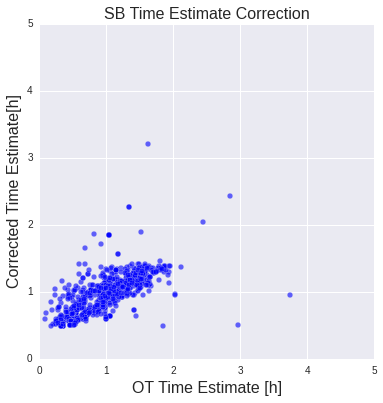

In [25]:
# sns.set_style('darkgrid')
# color = sns.color_palette()[1]

fig = plt.figure(figsize=[6,6])
ax = plt.subplot()
ax.scatter(remaining_all.SB_ETC_exec, remaining_all.SB_ETC2_exec, alpha=0.6, s=30)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_title('SB Time Estimate Correction', fontsize=16)
ax.set_xlabel('OT Time Estimate [h]', fontsize=16)
ax.set_ylabel('Corrected Time Estimate[h]', fontsize=16)


In [ ]:
remaining.groupby(['CODE', 'Problem'])[['sbName']].count().unstack().head()